In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

import optuna

c:\Users\User\AppData\Local\anaconda3\envs\jmc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
df = pd.read_csv("apple_TI.csv", index_col='Date')

In [24]:
# 전처리
df['label'] = df['label'].map({'up': 1, 'down': 0})
df.index = pd.to_datetime(df.index)
idx = pd.Timestamp('2023-01-01')
train_data = df[df.index < idx]
test_data = df[df.index >= idx]


# 수익률 계산을 위한 데이터프레임 준비
calcu_df = df.copy()
calcu_df = calcu_df[['Open','Close', 'label']]
calcu_df = calcu_df[calcu_df.index >= idx]
calcu_df.head(5)

,Open,Close,label
Date,,,
2023-01-03,130.279999,124.048042,1
2023-01-04,126.889999,125.327507,0
2023-01-05,127.129997,123.998451,1
2023-01-06,126.010002,128.560867,1
2023-01-09,130.470001,129.086533,1


# KNN 예측 결과

In [25]:
## 변수 집합
select_knn = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select_knn]
train_y = train_data['label']
test_x = test_data[select_knn]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_knn = scaler.fit_transform(train_x)
test_x_knn = scaler.transform(test_x)

# 모델 선언
knn = KNeighborsClassifier()
knn.fit(train_x_knn, train_y)
y_pred_knn = knn.predict(test_x_knn)

In [5]:
# 수익률 계산용 데이터프레임에 랜덤포레스트 예측값 추가
calcu_df['knn_predict'] = y_pred_knn
calcu_df.head(5)
calcu_df['knn_predict'].value_counts()

knn_predict
1    203
0    171
Name: count, dtype: int64

# Naive Baise 예측 결과

In [6]:
## 변수 집합
select_nb = ['ht_dcperiod', 'ht_dcphase', 'ht_trendmode', 'sine', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select_nb]
train_y = train_data['label']
test_x = test_data[select_nb]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_nb = scaler.fit_transform(train_x)
test_x_nb = scaler.transform(test_x)

# 모델 선언
nb = GaussianNB()
nb.fit(train_x_nb, train_y)
y_pred_nb = nb.predict(test_x_nb)

In [7]:
# 수익률 계산용 데이터프레임에 랜덤포레스트 예측값 추가
calcu_df['nb_predict'] = y_pred_nb
calcu_df.head(5)
calcu_df['nb_predict'].value_counts()

nb_predict
1    284
0     90
Name: count, dtype: int64

# Logistic 예측 결과

In [44]:
## 변수 집합
select_lr = ['cmo', 'rsi', 'ht_dcphase', 'ht_trendmode', 'leadsine', 'fastd', 'ppo', 'sine']

# 독립, 종속 변수 분할
train_x = train_data[select_lr]
train_y = train_data['label']
test_x = test_data[select_lr]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_lr = scaler.fit_transform(train_x)
test_x_lr = scaler.transform(test_x)

# optuna를 활용하여 파라미터 최적화
def objective(trial):
    # Hyperparameter space
    tol = trial.suggest_float('tol', 1e-6, 1e-1, log=True)
    C = trial.suggest_float('C', 1e-5, 1, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 1000)

    model = LogisticRegression(tol=tol, C=C, max_iter=max_iter, random_state=123)

    cv_scores = cross_val_score(model, train_x_lr, train_y, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    return mean_cv_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-22 23:23:55,591] A new study created in memory with name: no-name-766893b2-3e5c-4021-83a1-e431ed37e5a0
[I 2024-07-22 23:23:55,625] Trial 0 finished with value: 0.525196732529296 and parameters: {'tol': 0.00011187652657789197, 'C': 7.368279147957016e-05, 'max_iter': 526}. Best is trial 0 with value: 0.525196732529296.
[I 2024-07-22 23:23:55,674] Trial 1 finished with value: 0.5177903943204173 and parameters: {'tol': 1.6364007938594008e-06, 'C': 0.08745216314403383, 'max_iter': 256}. Best is trial 0 with value: 0.525196732529296.
[I 2024-07-22 23:23:55,708] Trial 2 finished with value: 0.525196732529296 and parameters: {'tol': 1.3146788488964636e-05, 'C': 2.5506908187420215e-05, 'max_iter': 638}. Best is trial 0 with value: 0.525196732529296.
[I 2024-07-22 23:23:55,741] Trial 3 finished with value: 0.525196732529296 and parameters: {'tol': 3.05937488856496e-06, 'C': 4.1631728605976884e-05, 'max_iter': 687}. Best is trial 0 with value: 0.525196732529296.
[I 2024-07-22 23:23:55,

Best trial: 0.5293484304165598
Best parameters: {'tol': 3.6351896149490584e-05, 'C': 0.0034546601197551585, 'max_iter': 101}


In [45]:
best_params = study.best_params
lr_optuna = LogisticRegression(**best_params, random_state = 123)
lr_optuna.fit(train_x_lr, train_y)

y_pred_lr = lr_optuna.predict(test_x_lr)

In [46]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['lr_predict'] = y_pred_lr
calcu_df.head(5)
calcu_df['lr_predict'].value_counts()

lr_predict
1    355
0     19
Name: count, dtype: int64

# Random Forest 예측 결과

In [34]:
## 변수 집합
select_rf = ['cmo', 'ht_dcperiod', 'ppo', 'roc', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select_rf]
train_y = train_data['label']
test_x = test_data[select_rf]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_rf = scaler.fit_transform(train_x)
test_x_rf = scaler.transform(test_x)

# 변수 선택 모델 optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        random_state=123
    )
    
    scores = cross_val_score(model, train_x_rf, train_y, cv=5, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-22 23:22:38,834] A new study created in memory with name: no-name-23da2d9b-f6ea-41bb-a6e2-217a9311cef4
[I 2024-07-22 23:22:42,697] Trial 0 finished with value: 0.4734336241553332 and parameters: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 11, 'n_estimators': 191}. Best is trial 0 with value: 0.4734336241553332.
[I 2024-07-22 23:22:46,718] Trial 1 finished with value: 0.4840614575314345 and parameters: {'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 2, 'n_estimators': 228}. Best is trial 1 with value: 0.4840614575314345.
[I 2024-07-22 23:22:47,920] Trial 2 finished with value: 0.4951511846719699 and parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 10, 'n_estimators': 120}. Best is trial 2 with value: 0.4951511846719699.
[I 2024-07-22 23:22:52,815] Trial 3 finished with value: 0.4706558463775554 and parameters: {'max_depth': 12, 'min_samples_split': 8, 'min_samples_leaf': 13, 'n_estimators': 289}. Best is trial 2 with va

Best trial: 0.4951511846719699
Best parameters: {'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 10, 'n_estimators': 120}


In [39]:
best_params = study.best_params
rf_optuna = RandomForestClassifier(**best_params, random_state = 123)
rf_optuna.fit(train_x_rf, train_y)

y_pred_rf = rf_optuna.predict(test_x_rf)

In [40]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['rf_predict'] = y_pred_rf
calcu_df.head(5)
calcu_df['rf_predict'].value_counts()

rf_predict
1    342
0     32
Name: count, dtype: int64

# XGB 예측 결과

In [53]:
## 변수 집합
select_xg = ['leadsine', 'ppo', 'ht_dcphase', 'fastk', 'roc', 'ht_dcperiod']

# 독립, 종속 변수 분할
train_x = train_data[select_xg]
train_y = train_data['label']
test_x = test_data[select_xg]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_xg = scaler.fit_transform(train_x)
test_x_xg = scaler.transform(test_x)

# 선택 변수로 optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }
    
    model = xgb.XGBClassifier(**param, random_state=123)
    scores = cross_val_score(model, train_x_xg, train_y, cv=5, scoring='accuracy')

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-22 23:24:51,941] A new study created in memory with name: no-name-d7621758-37d3-4d5b-8a7d-b7483761e387
[I 2024-07-22 23:24:52,477] Trial 0 finished with value: 0.5118039517577623 and parameters: {'max_depth': 9, 'learning_rate': 0.1954169936087099, 'n_estimators': 461, 'subsample': 0.6375792290375542, 'colsample_bytree': 0.706439508640728, 'gamma': 2.876223879783457, 'reg_alpha': 2.960537489366425, 'reg_lambda': 1.4173649305010583}. Best is trial 0 with value: 0.5118039517577623.
[I 2024-07-22 23:24:53,006] Trial 1 finished with value: 0.5210396886493884 and parameters: {'max_depth': 7, 'learning_rate': 0.002714546694396268, 'n_estimators': 387, 'subsample': 0.8661496959720469, 'colsample_bytree': 0.5732392945433894, 'gamma': 2.4328178021767433, 'reg_alpha': 4.449350916099425, 'reg_lambda': 2.561130341035884}. Best is trial 1 with value: 0.5210396886493884.
[I 2024-07-22 23:24:53,594] Trial 2 finished with value: 0.5076415618852108 and parameters: {'max_depth': 3, 'learning_

Best trial: 0.525196732529296
Best parameters: {'max_depth': 6, 'learning_rate': 0.006248903710667821, 'n_estimators': 375, 'subsample': 0.9509311000432139, 'colsample_bytree': 0.5521037987477937, 'gamma': 4.487891937368995, 'reg_alpha': 4.969671301574669, 'reg_lambda': 1.2427385584043633}


In [54]:
best_params = study.best_params
xg_optuna = xgb.XGBClassifier(**best_params, random_state = 123)
xg_optuna.fit(train_x_xg, train_y)

y_pred_xg = rf_optuna.predict(test_x_xg)

In [55]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['xg_predict'] = y_pred_xg
calcu_df.head(5)
calcu_df['xg_predict'].value_counts()

xg_predict
1    358
0     16
Name: count, dtype: int64

In [57]:
calcu_df.to_csv("./models_predict.csv")

# Bench Mark(Buy and Hold)

Close는 수정종가 이지만 Open은 수정된 가격이 아니어서 꾸준히 2정도의 차이를 보임 -> 내일의 Open 가격이 오늘의 Close 가격으로 보고 진행

In [17]:
calcu_df = pd.read_csv('./models_predict.csv', index_col='Date')

In [6]:
bt_df = calcu_df.copy()

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,label,knn_predict,nb_predict,lr_predict,rf_predict,xg_predict
Date,,,,,,,,
2023-01-03,130.279999,124.048042,1,1,0,1,1,1
2023-01-04,126.889999,125.327507,0,0,0,1,1,1
2023-01-05,127.129997,123.998451,1,1,1,1,1,1
2023-01-06,126.010002,128.560867,1,0,0,1,1,1
2023-01-09,130.470001,129.086533,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
2024-06-24,207.720001,208.139999,1,1,1,1,1,1
2024-06-25,209.149994,209.070007,1,1,1,1,1,0
2024-06-26,211.500000,213.250000,1,1,1,1,1,1


In [7]:
# 초기 자금
initial_capital = 10000.0

# 첫 번째 행의 Open 가격으로 주식 구매
first_open = bt_df.iloc[0]['Close']
shares_bought = initial_capital / first_open

# 포트폴리오 가치 계산
bt_df['Portfolio Value'] = bt_df['Close'] * shares_bought

# 최대 하락폭 (MDD) 계산
bt_df['Cumulative Max'] = bt_df['Portfolio Value'].cummax()
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100

# 최종 포트폴리오 가치
final_close = bt_df.iloc[-1]['Close']
final_portfolio_value = shares_bought * final_close

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")

Final Portfolio Value: 16978.905237375693
Return: 69.79%
MDD: -16.61%


# knn Predict를 이용한 전략

In [8]:
# 시그널 생성 홤수
def generate_knn_signal(row, prev_knn):
    if row['knn_predict'] == 1:
        return 'buy' if prev_knn == 0 else 'holding'
    else:
        return 'clear' if prev_knn == 1 else 'no_action'

In [9]:
# 값 초기화
calcu_df['knn_signal'] = ''
prev_knn = 0

# 시그널 생성 함수 적용
for idx, row in calcu_df.iterrows():
    calcu_df.at[idx, 'knn_signal'] = generate_knn_signal(row, prev_knn)
    prev_knn = row['knn_predict']

calcu_df

,Open,Close,label,knn_predict,nb_predict,lr_predict,rf_predict,xg_predict,knn_signal
Date,,,,,,,,,
2023-01-03,130.279999,124.048042,1,1,0,1,1,1,buy
2023-01-04,126.889999,125.327507,0,0,0,1,1,1,clear
2023-01-05,127.129997,123.998451,1,1,1,1,1,1,buy
2023-01-06,126.010002,128.560867,1,0,0,1,1,1,clear
2023-01-09,130.470001,129.086533,1,1,1,1,1,1,buy
...,...,...,...,...,...,...,...,...,...
2024-06-24,207.720001,208.139999,1,1,1,1,1,1,holding
2024-06-25,209.149994,209.070007,1,1,1,1,1,0,holding
2024-06-26,211.500000,213.250000,1,1,1,1,1,1,holding


# Backtrader

In [10]:
bt_df = calcu_df.copy()
bt_df = bt_df[['Open', 'Close', 'knn_signal']]

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,knn_signal
Date,,,
2023-01-03,130.279999,124.048042,buy
2023-01-04,126.889999,125.327507,clear
2023-01-05,127.129997,123.998451,buy
2023-01-06,126.010002,128.560867,clear
2023-01-09,130.470001,129.086533,buy
...,...,...,...
2024-06-24,207.720001,208.139999,holding
2024-06-25,209.149994,209.070007,holding
2024-06-26,211.500000,213.250000,holding


In [11]:
# 초기 자금
initial_capital = 10000.0
cash = initial_capital
shares = 0
num_trades = 0
wins = 0
profit_sum = 0
loss_sum = 0
win_trades = []
loss_trades = []

# 포트폴리오 가치 추적 리스트
portfolio_values = []
cumulative_max = initial_capital  # 누적 최대값 초기화

buy_price = 0

for index, row in bt_df.iterrows():
    signal = row['knn_signal']
    close_price = row['Close']
    
    if signal == 'buy' and cash > 0:
        # 매수: 현재 현금으로 최대한 많은 주식을 구매
        shares += cash / close_price
        cash = 0
        cumulative_max = shares * close_price  # 누적 최대값 초기화
        buy_price = close_price
        num_trades += 1  # 매수 시 거래 횟수 증가
    elif signal == 'clear' and shares > 0:
        # 매도: 현재 보유한 모든 주식을 판매
        cash += shares * close_price
        shares = 0
        cumulative_max = cash  # 누적 최대값 초기화
        num_trades += 1  # 매도 시 거래 횟수 증가
        
        trade_profit = close_price - buy_price
        
        if trade_profit > 0:
            wins += 1
            profit_sum += trade_profit
            win_trades.append(trade_profit)
        else:
            loss_sum += abs(trade_profit)
            loss_trades.append(trade_profit)
    
    # 현재 포트폴리오 가치 계산
    portfolio_value = cash + shares * close_price
    portfolio_values.append(portfolio_value)
    
    # 누적 최대값 갱신
    if portfolio_value > cumulative_max:
        cumulative_max = portfolio_value
    
    bt_df.loc[index, 'Cumulative Max'] = cumulative_max

# 백테스트 결과 DataFrame에 추가
bt_df['Portfolio Value'] = portfolio_values

# 최대 하락폭 (MDD) 계산
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100  # 퍼센트로 변환

# 최종 포트폴리오 가치
final_portfolio_value = portfolio_values[-1]

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# 승률 계산
win_rate = (wins / (num_trades / 2)) * 100  # 매수-매도 한 쌍을 한 거래로 간주하여 승률 계산

# Payoff Ratio 계산
average_profit_per_winning_trade = profit_sum / len(win_trades) if win_trades else 0
average_loss_per_losing_trade = loss_sum / len(loss_trades) if loss_trades else 0
payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')

# Profit Factor 계산
profit_factor = profit_sum / loss_sum if loss_sum != 0 else float('inf')


print(f"Payoff Ratio: {payoff_ratio}")
print(f"Profit Factor: {profit_factor}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.0f}%")
print(f"Number of Trades: {num_trades}")

Payoff Ratio: 1.0841724822694752
Profit Factor: 2.06978382978718
Final Portfolio Value: 14696.42340421698
Return: 46.96%
MDD: -6.50%
Win Rate: 65%
Number of Trades: 129


# 시각화

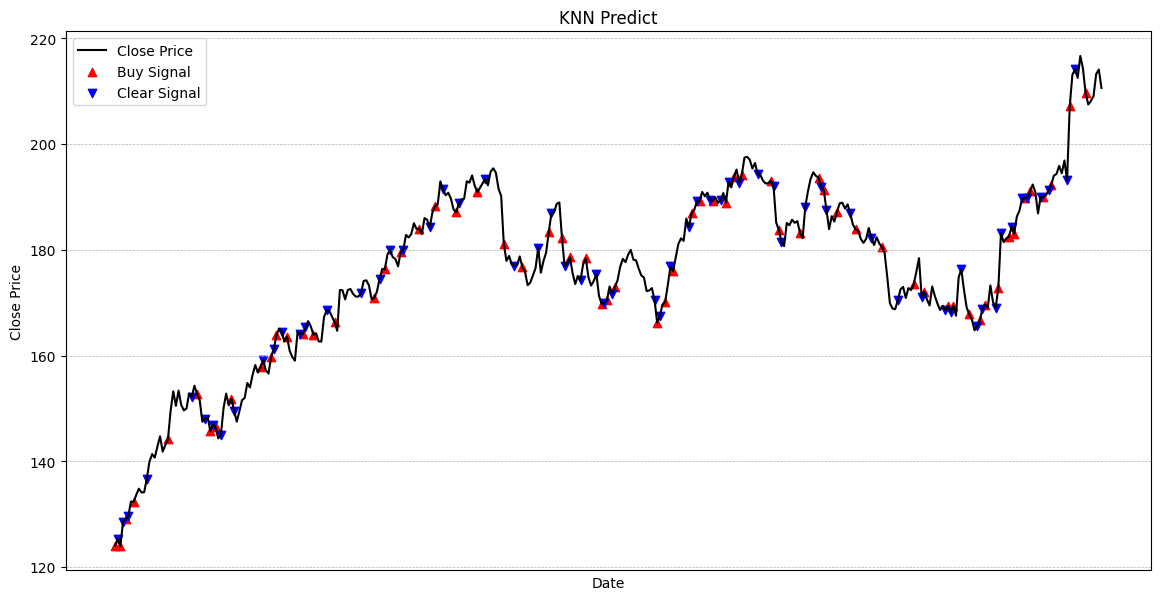

In [12]:
# Close 값 시각화
plt.figure(figsize=(14, 7))
plt.plot(calcu_df.index, calcu_df['Close'], label='Close Price', color='black')

# 'buy' 시그널 빨간색 점으로 표시
buy_signals = calcu_df[calcu_df['knn_signal'] == 'buy']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', color='red', marker='^', alpha=1)

# 'clear' 시그널 파란색 점으로 표시
clear_signals = calcu_df[calcu_df['knn_signal'] == 'clear']
plt.scatter(clear_signals.index, clear_signals['Close'], label='Clear Signal', color='blue', marker='v', alpha=1)

# 그래프 제목과 축 레이블 설정
plt.title('KNN Predict')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 그리드 설정 - 세로선 제거
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='x')

# x축 날짜 레이블 비활성화
plt.xticks([])

plt.show()

# Voting으로 새로운 전략 만들기

In [18]:
calcu_df['sum'] = calcu_df.iloc[:, 3:8].sum(axis=1)
print(calcu_df['sum'])

Date
2023-01-03    4
2023-01-04    3
2023-01-05    5
2023-01-06    3
2023-01-09    5
             ..
2024-06-24    5
2024-06-25    4
2024-06-26    5
2024-06-27    5
2024-06-28    4
Name: sum, Length: 374, dtype: int64


In [19]:
calcu_df['sum'].value_counts()

sum
4    155
5    144
3     53
2     21
1      1
Name: count, dtype: int64

In [26]:
# 시그널 생성 홤수 (5일때만 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] == 5:
        return 'holding' if prev_sum == 5 else 'buy'
    else:
        return 'clear' if prev_sum == 5 else 'no_action'

Payoff Ratio: 1.0417304131815148  
Profit Factor: 2.187633867681181  
Final Portfolio Value: 14205.642781518083  
Return: 42.06%  
MDD: -5.93%  
Win Rate: 68%  
Number of Trades: 124  

In [21]:
# 값 초기화
calcu_df['sum_signal'] = ''
prev_sum = 0

# 시그널 생성 함수 적용
for idx, row in calcu_df.iterrows():
    calcu_df.at[idx, 'sum_signal'] = generate_sum_signal(row, prev_sum)
    prev_sum = int(row['sum'])

calcu_df.head(10)

,Open,Close,label,knn_predict,nb_predict,lr_predict,rf_predict,xg_predict,sum,sum_signal
Date,,,,,,,,,,
2023-01-03,130.279999,124.048042,1,1,0,1,1,1,4,buy
2023-01-04,126.889999,125.327507,0,0,0,1,1,1,3,clear
2023-01-05,127.129997,123.998451,1,1,1,1,1,1,5,buy
2023-01-06,126.010002,128.560867,1,0,0,1,1,1,3,clear
2023-01-09,130.470001,129.086533,1,1,1,1,1,1,5,buy
2023-01-10,130.259995,129.661789,1,0,1,1,1,1,4,holding
2023-01-11,131.250000,132.399261,0,0,1,1,1,1,4,holding
2023-01-12,133.880005,132.319901,1,1,1,1,1,1,5,holding
2023-01-13,132.029999,133.658859,1,1,1,1,1,1,5,holding


# Backtrader

In [14]:
bt_df = calcu_df.copy()
bt_df = bt_df[['Open', 'Close', 'sum_signal']]

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,sum_signal
Date,,,
2023-01-03,130.279999,124.048042,buy
2023-01-04,126.889999,125.327507,clear
2023-01-05,127.129997,123.998451,buy
2023-01-06,126.010002,128.560867,clear
2023-01-09,130.470001,129.086533,buy
2023-01-10,130.259995,129.661789,holding
2023-01-11,131.250000,132.399261,holding
2023-01-12,133.880005,132.319901,holding
2023-01-13,132.029999,133.658859,holding


In [15]:
# 초기 자금
initial_capital = 10000.0
cash = initial_capital
shares = 0
num_trades = 0
wins = 0
profit_sum = 0
loss_sum = 0
win_trades = []
loss_trades = []

# 포트폴리오 가치 추적 리스트
portfolio_values = []
cumulative_max = initial_capital  # 누적 최대값 초기화

buy_price = 0

for index, row in bt_df.iterrows():
    signal = row['sum_signal']
    close_price = row['Close']
    
    if signal == 'buy' and cash > 0:
        # 매수: 현재 현금으로 최대한 많은 주식을 구매
        shares += cash / close_price
        cash = 0
        cumulative_max = shares * close_price  # 누적 최대값 초기화
        buy_price = close_price
        num_trades += 1  # 매수 시 거래 횟수 증가
    elif signal == 'clear' and shares > 0:
        # 매도: 현재 보유한 모든 주식을 판매
        cash += shares * close_price
        shares = 0
        cumulative_max = cash  # 누적 최대값 초기화
        num_trades += 1  # 매도 시 거래 횟수 증가
        
        trade_profit = close_price - buy_price
        
        if trade_profit > 0:
            wins += 1
            profit_sum += trade_profit
            win_trades.append(trade_profit)
        else:
            loss_sum += abs(trade_profit)
            loss_trades.append(trade_profit)
    
    # 현재 포트폴리오 가치 계산
    portfolio_value = cash + shares * close_price
    portfolio_values.append(portfolio_value)
    
    # 누적 최대값 갱신
    if portfolio_value > cumulative_max:
        cumulative_max = portfolio_value
    
    bt_df.loc[index, 'Cumulative Max'] = cumulative_max

# 백테스트 결과 DataFrame에 추가
bt_df['Portfolio Value'] = portfolio_values

# 최대 하락폭 (MDD) 계산
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100  # 퍼센트로 변환

# 최종 포트폴리오 가치
final_portfolio_value = portfolio_values[-1]

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# 승률 계산
win_rate = (wins / (num_trades / 2)) * 100  # 매수-매도 한 쌍을 한 거래로 간주하여 승률 계산

# Payoff Ratio 계산
average_profit_per_winning_trade = profit_sum / len(win_trades) if win_trades else 0
average_loss_per_losing_trade = loss_sum / len(loss_trades) if loss_trades else 0
payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')

# Profit Factor 계산
profit_factor = profit_sum / loss_sum if loss_sum != 0 else float('inf')

print(f"Payoff Ratio: {payoff_ratio}")
print(f"Profit Factor: {profit_factor}")
print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.0f}%")
print(f"Number of Trades: {num_trades}")

Payoff Ratio: 2.363033319030712
Profit Factor: 3.347630535293508
Final Portfolio Value: 19011.957025778207
Return: 90.12%
MDD: -7.65%
Win Rate: 58%
Number of Trades: 59


# 결과 시각화

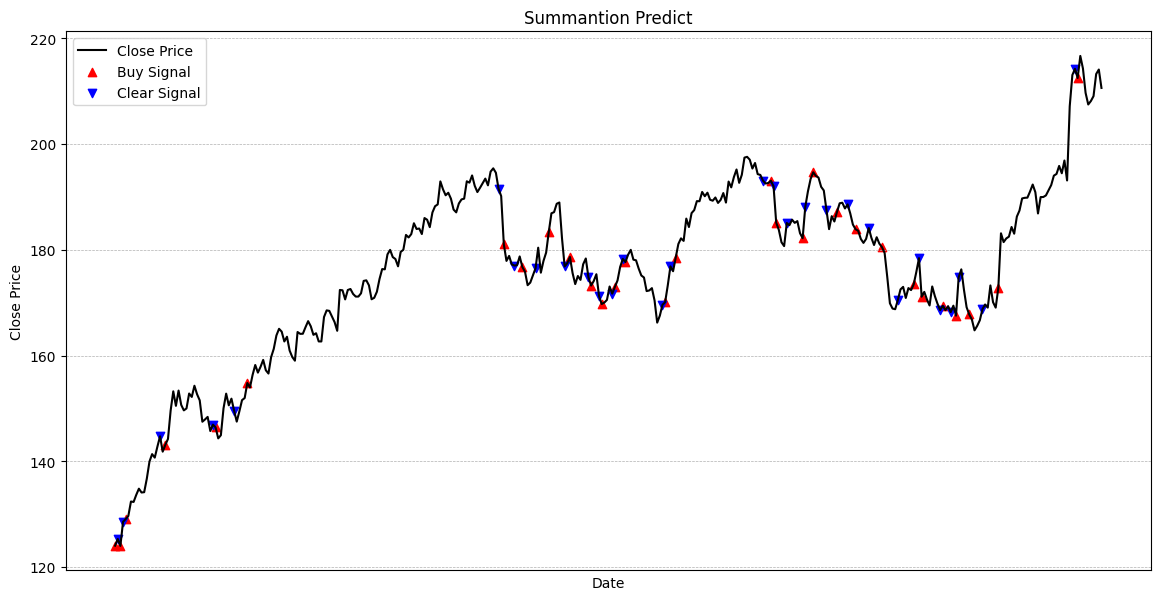

In [221]:
# Close 값 시각화
plt.figure(figsize=(14, 7))
plt.plot(calcu_df.index, calcu_df['Close'], label='Close Price', color='black')

# 'buy' 시그널 빨간색 점으로 표시
buy_signals = calcu_df[calcu_df['sum_signal'] == 'buy']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', color='red', marker='^', alpha=1)

# 'clear' 시그널 파란색 점으로 표시
clear_signals = calcu_df[calcu_df['sum_signal'] == 'clear']
plt.scatter(clear_signals.index, clear_signals['Close'], label='Clear Signal', color='blue', marker='v', alpha=1)

# 그래프 제목과 축 레이블 설정
plt.title('Summantion Predict')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 그리드 설정 - 세로선 제거
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='x')

# x축 날짜 레이블 비활성화
plt.xticks([])

plt.show()